In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress 
import numpy as np

In [2]:
#current_directory = os.getcwd()
#folder_path = "/Users/mseglar/GitHub/sensors-analysis/August_2023_Laser_Test_1064_532_PM_MM/data/"  # Replace with the path to your folder


In [3]:
def GetNumberOfFiles(wavelength,folder_path):
    count = 0
    for filename in os.listdir(folder_path):
        if wavelength in filename:
            count += 1
    #print(f"Number of files in the folder with '532' in their name: {count}")
    return count


In [4]:
# Create diagnostic plots 
def DeepAnalysis532(folder_path): 
    wavelength = '532'
    nfile = GetNumberOfFiles(wavelength,folder_path)
    Tfull= pd.DataFrame()
    outputpath =  f'{folder_path}/plots'
    slopes = [] 
    intercepts= []
    rCoes = []
    stErr = []
    if not os.path.exists(outputpath):
        os.makedirs(outputpath)
        print(f"Directory '{outputpath}' created.")
    else:
        print(f"Directory '{outputpath}' already exists.")

    for i in range(1, nfile+1):
        filename = f'{folder_path}/Laser_{wavelength}_Step_50_Temp_20_PM_MM_G_{i}.txt'
        T = pd.read_csv(filename,delimiter ='\t',header=None)

        # Rename DataFrame columns
        T.columns = ['date', 'time', 'LCurrent', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']
        
        Tfull = pd.concat([Tfull, T])
        # Create separate figures for each plot

        fig = plt.figure(i)
        plt.errorbar(T['LCurrent'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel('Amplitude (mA)')
        plt.grid()
        plt.title(f'Plot G {i}')
        plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_Temp_20_PM_MM_G_{i}_LCurrent_PM.png',dpi=199)  # Display the current figure
        plt.close(fig)

        fig = plt.figure(i + 1)
        plt.errorbar(T['LCurrent'], T['meanRefPD'], yerr=T['stdRefPD'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean ref PD (V)')
        plt.xlabel('Amplitude (mA)')
        plt.grid()
        plt.title(f'Plot G {i}')
        plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_Temp_20_PM_MM_G_{i}_LCurrent_PD.png',dpi=199)  # Display the current figure
        plt.close(fig)

        #Linear fit 
        slope, intercept, r, p, se = linregress(T['meanRefPD'], T['meanPM'])
         
        slopes.append(slope)
        intercepts.append(intercept)
        rCoes.append(r)
        stErr.append(se)

        fig = plt.figure(i + 2)
        plt.errorbar(T['meanRefPD'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.plot(T['meanRefPD'], intercept + slope*T['meanRefPD'], 'r', label='fitted line')
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel('Mean ref PD (V)')
        plt.grid()
        plt.title(f'Plot G {i}')
        plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_Temp_20_PM_MM_G_{i}_PD_PM.png',dpi=199)  # Display the current figure
        plt.close(fig)

        plt.figure(101)
        plt.grid()
        plt.errorbar(T['LCurrent'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel('Laser current (mA)')
        plt.title(f'all datasets')
        
        
        plt.figure(102)
        plt.grid()
        plt.errorbar(T['LCurrent'], T['meanRefPD'], yerr=T['stdRefPD'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean ref PD (V)')
        plt.xlabel('Laser current (mA)')
        plt.title(f'all datasets')
        

        plt.figure(103)
        plt.grid()
        plt.errorbar(T['meanRefPD'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel('Mean ref PD (V)')
        plt.title(f'all datasets')
        
    #plt.figure()
    #x = np.linspace(1,nfile,num=nfile)
    #plt.plot(x,slopes)
    #print(x,slopes)
    #plt.show()

    x=Tfull['meanRefPD']
    y=Tfull['meanPM']

    res = linregress(x, y)
    datasets=  nfile
    slopes_micro=[i * 1e6 for i in slopes]
    stErr_micro=[i * 1e6 for i in stErr]


    # Customize the plot
    fig = plt.figure(100)
    plt.errorbar(range(len(slopes)), slopes_micro,stErr_micro)
    plt.title('Calibration for Different Datasets')
    plt.xlabel('Dataset Index')
    plt.ylabel('Calibration coefficient ($\mu$W/V)')
    plt.xticks(range(datasets), [f'D {i+1}' for i in range(10)])  # Label the x-axis with dataset identifiers
    #plt.legend()
    plt.axhline(y=res.slope*1e6, color='red', linestyle='--', label='Horizontal Line at y=m_all')
    plt.axhline(y=np.mean(slopes_micro), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
    plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr)*1e6, (res.slope+res.stderr)*1e6, color='red', alpha=0.3, label='Shaded Region')
    plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes_micro)-np.std(slopes_micro)), (np.mean(slopes_micro)+np.std(slopes_micro)), color='purple', alpha=0.2, label='Shaded Region')
    #plt.ylim([0.00064*1e6, 0.000665*1e6])
    plt.xlim([-1,10])
    plt.grid()
    # Show the plot
    #plt.show()
    plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_Temp_20_PM_MM_GAll_Cal_coeff.png',dpi=199)

    plt.figure(101)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}__Step_50_Temp_20_PM_MM_G_all_trend_LCurrent_PM.png',dpi=199)

    plt.figure(102)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}__Step_50_Temp_20_PM_MM_G_all_trend_LCurrent_PD.png',dpi=199)

    plt.figure(103)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}__Step_50_Temp_20_PM_MM_G_all_trend_PD_PM.png',dpi=199)

    return Tfull, slopes, intercepts, rCoes,stErr, res

Directory '../data/Laser_Test_PM_MM_August_2023//plots' already exists.


[0.0006596168795339127,
 0.0006552466509155211,
 0.0006553904599488836,
 0.0006550228678280029,
 0.000648582142751374,
 0.000647569328970771,
 0.0006462954772820959,
 0.0006510185128732034,
 0.0006516624112954694,
 0.0006506402642711994]

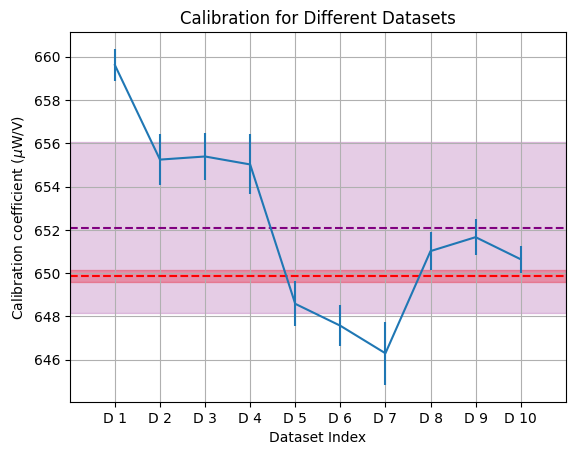

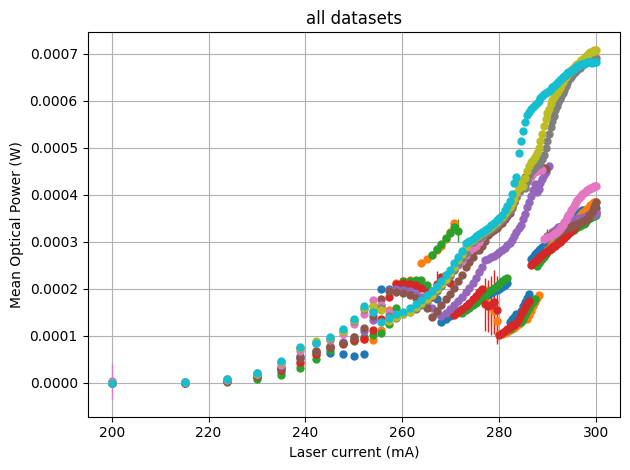

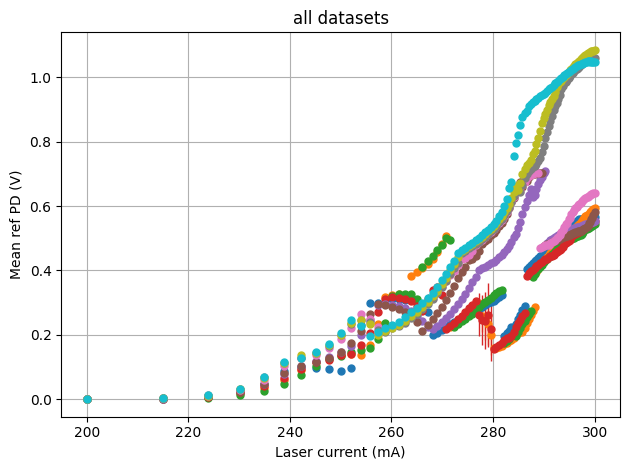

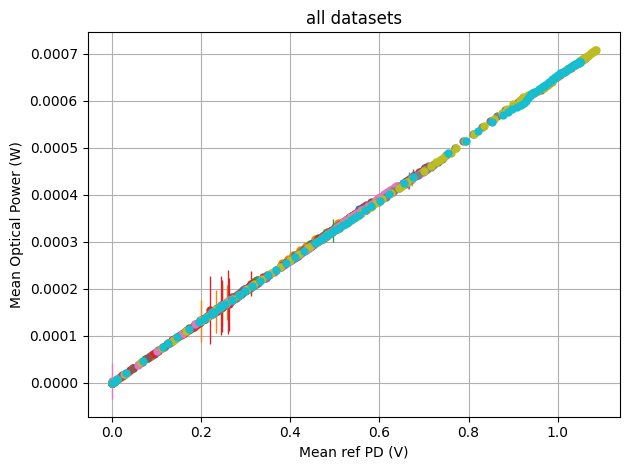

In [5]:
#Obtain a deep look of the data
Tfull, slopes, intercepts, rCoes,stErr, res=DeepAnalysis532('../data/Laser_Test_PM_MM_August_2023/')

slopes

In [6]:
(np.mean(slopes)-res.slope)/np.mean(slopes)
(np.max(slopes_micro)-np.min(slopes_micro))/np.max(slopes_micro)

NameError: name 'slopes_micro' is not defined

In [ ]:
# Create diagnostic plots 
def DeepAnalysis1064(folder_path): 
    wavelength = '1064'
    nfile = GetNumberOfFiles(wavelength,folder_path)
    Tfull= pd.DataFrame()
    outputpath =  f'{folder_path}/plots'
    slopes = [] 
    intercepts= []
    rCoes = []
    stErr = []
    if not os.path.exists(outputpath):
        os.makedirs(outputpath)
        print(f"Directory '{outputpath}' created.")
    else:
        print(f"Directory '{outputpath}' already exists.")

    for i in range(1, nfile+1):
        filename = f'{folder_path}/Laser_{wavelength}_Step_50_Temp_25_PM_MM_G_{i}.txt'
        T = pd.read_csv(filename,delimiter ='\t',header=None)

        # Rename DataFrame columns
        T.columns = ['date', 'time', 'LPower', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']
        
        Tfull = pd.concat([Tfull, T])
        # Create separate figures for each plot

        fig = plt.figure(i)
        plt.errorbar(T['LPower'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel('Laser Power (mW)')
        plt.grid()
        plt.title(f'Plot G {i}')
        plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_Temp_25_PM_MM_G_{i}_LPower_PM.png')  # Display the current figure
        plt.close(fig)

        fig = plt.figure(i + 1)
        plt.errorbar(T['LPower'], T['meanRefPD'], yerr=T['stdRefPD'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean ref PD (V)')
        plt.xlabel('Laser Power (mW)')
        plt.grid()
        plt.title(f'Plot G {i}')
        plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_Temp_25_PM_MM_G_{i}_LPower_PD.png')  # Display the current figure
        plt.close(fig)

        #Linear fit 
        slope, intercept, r, p, se = linregress(T['meanRefPD'], T['meanPM'])
         
        slopes.append(slope)
        intercepts.append(intercept)
        rCoes.append(r)
        stErr.append(se)

        fig = plt.figure(i + 2)
        plt.errorbar(T['meanRefPD'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.plot(T['meanRefPD'], intercept + slope*T['meanRefPD'], 'r', label='fitted line')
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel('Mean ref PD (V)')
        plt.grid()
        plt.title(f'Plot G {i}')
        plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_Temp_25_PM_MM_G_{i}_PD_PM.png')  # Display the current figure
        plt.close(fig)

        plt.figure(101)
        plt.grid()
        plt.errorbar(T['LPower'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel('Laser Power (mW)')
        plt.title(f'all datasets')
        
        
        plt.figure(102)
        plt.grid()
        plt.errorbar(T['LPower'], T['meanRefPD'], yerr=T['stdRefPD'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean ref PD (V)')
        plt.xlabel('Laser Power (mW)')
        plt.title(f'all datasets')
        

        plt.figure(103)
        plt.grid()
        plt.errorbar(T['meanRefPD'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel('Mean ref PD (V)')
        plt.title(f'all datasets')
        
    #plt.figure()
    #x = np.linspace(1,nfile,num=nfile)
    #plt.plot(x,slopes)
    #print(x,slopes)
    #plt.show()

    x=Tfull['meanRefPD']
    y=Tfull['meanPM']

    res = linregress(x, y)
    datasets=  nfile
    slopes_micro=[i * 1e6 for i in slopes]
    stErr_micro=[i * 1e6 for i in stErr]


    # Customize the plot
    fig = plt.figure(100)
    plt.errorbar(range(len(slopes)), slopes_micro,stErr_micro)
    plt.title('Calibration for Different Datasets')
    plt.xlabel('Dataset Index')
    plt.ylabel('Calibration coefficient ($\mu$W/V)')
    plt.xticks(range(datasets), [f'D {i+1}' for i in range(10)])  # Label the x-axis with dataset identifiers
    #plt.legend()
    plt.axhline(y=res.slope*1e6, color='red', linestyle='--', label='Horizontal Line at y=m_all')
    plt.axhline(y=np.mean(slopes_micro), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
    plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr)*1e6, (res.slope+res.stderr)*1e6, color='red', alpha=0.3, label='Shaded Region')
    plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes_micro)-np.std(slopes_micro)), (np.mean(slopes_micro)+np.std(slopes_micro)), color='purple', alpha=0.2, label='Shaded Region')
    #plt.ylim([0.00064*1e6, 0.000665*1e6])
    plt.xlim([-1,10])
    plt.grid()
    # Show the plot
    #plt.show()
    plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_Temp_25_PM_MM_GAll_Cal_coeff.png')

    plt.figure(101)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}__Step_50_Temp_25_PM_MM_G_all_trend_LPower_PM.png',dpi=199)

    plt.figure(102)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}__Step_50_Temp_25_PM_MM_G_all_trend_LPower_PD.png',dpi=199)

    plt.figure(103)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}__Step_50_Temp_25_PM_MM_G_all_trend_PD_PM.png',dpi=199)

  
    return Tfull, slopes, intercepts, rCoes,stErr, res

Directory '../data/Laser_Test_PM_MM_August_2023//plots' already exists.


0.0001403080006991385

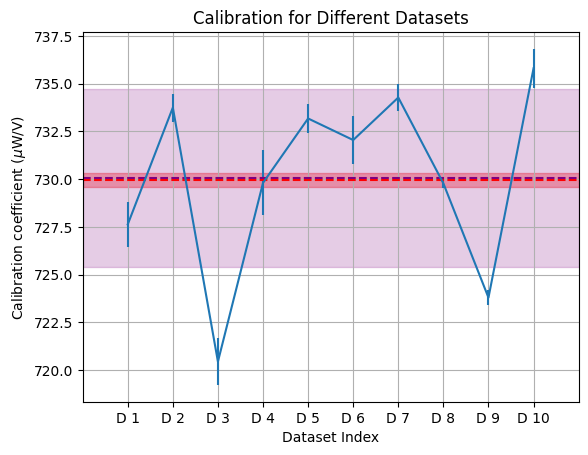

In [ ]:
Tfull, slopes, intercepts, rCoes,stErr, res=DeepAnalysis1064('../data/Laser_Test_PM_MM_August_2023/')
(np.mean(slopes)-res.slope)/np.mean(slopes)
